# Implementing MonoBERT for re-ranking documents 

Based on: 
- Lin, Jimmy, Rodrigo Nogueira, and Andrew Yates. "Pretrained transformers for text ranking: Bert and beyond." Synthesis Lectures on Human Language Technologies 14.4 (2021): 1-325.
- Nogueira, Rodrigo, and Kyunghyun Cho. "Passage Re-ranking with BERT." arXiv preprint arXiv:1901.04085 (2019).

Implementation sources:

- Relevance-Score: https://radimrehurek.com/gensim_3.8.3/summarization/bm25.html (important: note the version 3.8.3 as gensim removed bm25 scoring in later versions)
- Using BERT with tensorflow-hub: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- Fine-tuning BERT: https://www.tensorflow.org/text/tutorials/fine_tune_bert (outdated)
- Preprocessing and Loading: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3 and https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

- BERT-model: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

Additional notes:
- For finetuning BERT the authors choose an equal number of negative instances from the training set
- For re-ranking 1000 documents are retrieved with the initial retrieval

In [1]:
import pandas as pd
from monobert import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\users\pascal quindeau\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Read the corpus data and preprocess it according to gensim documentation.  
Documents are presented as list of strings. Thus, the corpus is a nested list. 

In [2]:
docs_df = pd.read_csv("../corpus/dev.docs", delimiter="\t", header=None, names=["docid", "text"])

In [3]:
corpus = docs_df["text"].tolist()
export_dir = "../models/mono_bert/"
bm25 = BM25Retrieval(corpus, docs_df["docid"].tolist())
monobert = MonoBERT(corpus, docs_df["docid"].tolist(), export_dir, bm25, 50)

Initilizing BM25 based Retrieval System...
Finished.

Corpus size: 3193
Avg. document len: 146.26
Avg. idf: 6.89
Loading BERT model with tensorflow...
BERT model loaded!


### Load querie data
Load the queries "xyz.titles.queries" and the groundtruth "xyz.2-1-0.qrel".

In [4]:
queries_df = pd.read_csv("../query/dev.titles.queries", delimiter="\t", header=None, names=["queryid", "text"])
relqueries_df = pd.read_csv("../qrel/dev.2-1-0.qrel", delimiter="\t", header=None, names=["queryid", "0", "docid", "rellvl"])

relqueries_df.loc[:, "rellvl"] = 1

In [5]:
query = queries_df.iloc[0]
query_text = query["text"]
query_id = query["queryid"]

In [6]:
groundtruth = relqueries_df[relqueries_df["queryid"]==query_id]["docid"]
groundtruth = set(groundtruth.values)

In [7]:
ids, scores = monobert.initial_retriever.retrieve_k(query_text, k=45)

In [8]:
from retrieval_metrics import *

In [10]:
scorer = RetrievalScorer(monobert)

In [11]:
query_text

'why deep fried foods may cause cancer'

In [12]:
#precision at k
ids, scores = monobert.initial_retriever.retrieve_k(query_text, k=45)
groundtruth = relqueries_df[relqueries_df["queryid"]==query_id]["docid"]
groundtruth = set(groundtruth.values)

precision(groundtruth, ids)

0.2

In [13]:
precision_recall_fscore(groundtruth, ids)

(0.2, 0.1836734693877551, 0.19148936170212766)

In [14]:
monobert.retrieve_k(query_text, k=10)

Initial Retrieval...
['MED-2418', 'MED-2195', 'MED-4070', 'MED-2185', 'MED-5033', 'MED-4976', 'MED-708', 'MED-4053', 'MED-4818', 'MED-4878', 'MED-2697', 'MED-1109', 'MED-1165', 'MED-1208', 'MED-3498', 'MED-2421', 'MED-2201', 'MED-5088', 'MED-4072', 'MED-5105', 'MED-1564', 'MED-4898', 'MED-2438', 'MED-1151', 'MED-3699', 'MED-4978', 'MED-4349', 'MED-5142', 'MED-4024', 'MED-2797', 'MED-2420', 'MED-2176', 'MED-1565', 'MED-5089', 'MED-4440', 'MED-4786', 'MED-3553', 'MED-3722', 'MED-5086', 'MED-2194', 'MED-4212', 'MED-2494', 'MED-1467', 'MED-4030', 'MED-1196', 'MED-4299', 'MED-5076', 'MED-3849', 'MED-5183', 'MED-1103'] (14.279703055168344, 13.8121919805223, 12.928584187105121, 11.899066260974287, 10.35737497400919, 9.671366724175448, 9.286288027652292, 9.102348689419559, 8.500304826835558, 8.330847393962047, 7.847780594606345, 7.717370277101566, 7.570026939238266, 7.5451062881858055, 7.520349177129243, 7.409978384907653, 7.347776639367393, 7.187807981549968, 6.635561449916934, 6.588972944674

(('MED-5033',
  'MED-2418',
  'MED-2176',
  'MED-4070',
  'MED-2185',
  'MED-708',
  'MED-1109',
  'MED-2194',
  'MED-2195',
  'MED-2421'),
 (0.9892669320106506,
  0.9877183437347412,
  0.9863827228546143,
  0.9862232208251953,
  0.9803014397621155,
  0.9791430234909058,
  0.9771043062210083,
  0.9759024977684021,
  0.9757089614868164,
  0.975145697593689))

In [15]:
scorer.rPrecision(groundtruth, query_text)

Initial Retrieval...
['MED-2418', 'MED-2195', 'MED-4070', 'MED-2185', 'MED-5033', 'MED-4976', 'MED-708', 'MED-4053', 'MED-4818', 'MED-4878', 'MED-2697', 'MED-1109', 'MED-1165', 'MED-1208', 'MED-3498', 'MED-2421', 'MED-2201', 'MED-5088', 'MED-4072', 'MED-5105', 'MED-1564', 'MED-4898', 'MED-2438', 'MED-1151', 'MED-3699', 'MED-4978', 'MED-4349', 'MED-5142', 'MED-4024', 'MED-2797', 'MED-2420', 'MED-2176', 'MED-1565', 'MED-5089', 'MED-4440', 'MED-4786', 'MED-3553', 'MED-3722', 'MED-5086', 'MED-2194', 'MED-4212', 'MED-2494', 'MED-1467', 'MED-4030', 'MED-1196', 'MED-4299', 'MED-5076', 'MED-3849', 'MED-5183', 'MED-1103'] (14.279703055168344, 13.8121919805223, 12.928584187105121, 11.899066260974287, 10.35737497400919, 9.671366724175448, 9.286288027652292, 9.102348689419559, 8.500304826835558, 8.330847393962047, 7.847780594606345, 7.717370277101566, 7.570026939238266, 7.5451062881858055, 7.520349177129243, 7.409978384907653, 7.347776639367393, 7.187807981549968, 6.635561449916934, 6.588972944674

0.1836734693877551

In [16]:
scorer.aveP(query_text, groundtruth)

Initial Retrieval...
['MED-2418', 'MED-2195', 'MED-4070', 'MED-2185', 'MED-5033', 'MED-4976', 'MED-708', 'MED-4053', 'MED-4818', 'MED-4878', 'MED-2697', 'MED-1109', 'MED-1165', 'MED-1208', 'MED-3498', 'MED-2421', 'MED-2201', 'MED-5088', 'MED-4072', 'MED-5105', 'MED-1564', 'MED-4898', 'MED-2438', 'MED-1151', 'MED-3699', 'MED-4978', 'MED-4349', 'MED-5142', 'MED-4024', 'MED-2797', 'MED-2420', 'MED-2176', 'MED-1565', 'MED-5089', 'MED-4440', 'MED-4786', 'MED-3553', 'MED-3722', 'MED-5086', 'MED-2194', 'MED-4212', 'MED-2494', 'MED-1467', 'MED-4030', 'MED-1196', 'MED-4299', 'MED-5076', 'MED-3849', 'MED-5183', 'MED-1103'] (14.279703055168344, 13.8121919805223, 12.928584187105121, 11.899066260974287, 10.35737497400919, 9.671366724175448, 9.286288027652292, 9.102348689419559, 8.500304826835558, 8.330847393962047, 7.847780594606345, 7.717370277101566, 7.570026939238266, 7.5451062881858055, 7.520349177129243, 7.409978384907653, 7.347776639367393, 7.187807981549968, 6.635561449916934, 6.588972944674

(0.07386363636363637,
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 0     0.5000
 1     0.3125
 2     0.0000
 3     0.0000
 4     0.0000
 5     0.0000
 6     0.0000
 7     0.0000
 8     0.0000
 9     0.0000
 10    0.0000
 dtype: float64)

In [16]:
queries = ["PLAIN-1666", "PLAIN-1027", "PLAIN-142"]
groundtruths = [set(relqueries_df[relqueries_df["queryid"]==query_id]["docid"].tolist()) for query_id in queries]
queries = [queries_df[queries_df["queryid"]==query_id]["text"].tolist()[0] for query_id in queries]
scorer.MAP(queries, groundtruths=groundtruths)

('MED-3461', 'MED-4829', 'MED-4828', 'MED-2300', 'MED-3453', 'MED-5233', 'MED-2704', 'MED-3460', 'MED-4830', 'MED-4315', 'MED-3171', 'MED-4405', 'MED-3534', 'MED-4747', 'MED-1460', 'MED-1569', 'MED-3462', 'MED-3220', 'MED-3235', 'MED-1750', 'MED-3459', 'MED-3231', 'MED-1466', 'MED-2271', 'MED-1752', 'MED-1470', 'MED-3466', 'MED-1474', 'MED-4961', 'MED-3465', 'MED-1491', 'MED-1472', 'MED-4626', 'MED-1457', 'MED-1473', 'MED-3165', 'MED-4399', 'MED-4874', 'MED-2982', 'MED-1236', 'MED-1467', 'MED-1465', 'MED-5110', 'MED-1458', 'MED-3593', 'MED-1459', 'MED-4746', 'MED-3024', 'MED-4966', 'MED-4937') (0.9504196643829346, 0.9270719885826111, 0.9228737354278564, 0.9203592538833618, 0.91777503490448, 0.9146037101745605, 0.9144027829170227, 0.914323091506958, 0.9084426164627075, 0.9080778956413269, 0.9057374596595764, 0.9046251773834229, 0.9040288925170898, 0.8948942422866821, 0.892023503780365, 0.8913775682449341, 0.8887010812759399, 0.8864936232566833, 0.8864936232566833, 0.8856745958328247, 0.

0.10294691956133963

In [18]:
groundtruth = relqueries_df[relqueries_df["queryid"]=="PLAIN-142"]["docid"]
groundtruth = set(groundtruth.values)
print(query_text)
_map, recalls, precisions = scorer.aveP(query_text, groundtruth)

why deep fried foods may cause cancer
Initial Retrieval...
['MED-2418', 'MED-2195', 'MED-4070', 'MED-2185', 'MED-5033', 'MED-4976', 'MED-708', 'MED-4053', 'MED-4818', 'MED-4878', 'MED-2697', 'MED-1109', 'MED-1165', 'MED-1208', 'MED-3498', 'MED-2421', 'MED-2201', 'MED-5088', 'MED-4072', 'MED-5105', 'MED-1564', 'MED-4898', 'MED-2438', 'MED-1151', 'MED-3699', 'MED-4978', 'MED-4349', 'MED-5142', 'MED-4024', 'MED-2797', 'MED-2420', 'MED-2176', 'MED-1565', 'MED-5089', 'MED-4440', 'MED-4786', 'MED-3553', 'MED-3722', 'MED-5086', 'MED-2194', 'MED-4212', 'MED-2494', 'MED-1467', 'MED-4030', 'MED-1196', 'MED-4299', 'MED-5076', 'MED-3849', 'MED-5183', 'MED-1103'] (14.279703055168344, 13.8121919805223, 12.928584187105121, 11.899066260974287, 10.35737497400919, 9.671366724175448, 9.286288027652292, 9.102348689419559, 8.500304826835558, 8.330847393962047, 7.847780594606345, 7.717370277101566, 7.570026939238266, 7.5451062881858055, 7.520349177129243, 7.409978384907653, 7.347776639367393, 7.187807981549

Text(0, 0.5, 'Precision')

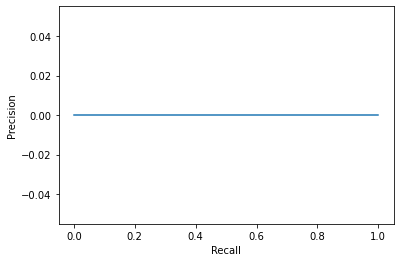

In [19]:
from matplotlib import pyplot as plt 
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")